In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import time
from sklearn.model_selection import train_test_split

In [2]:
# Data path
IMG_DIR = 'USA_segmentation/RGB_images'
MASK_DIR = 'USA_segmentation/masks'

# Load image and mask
def load_images_and_masks(img_dir, mask_dir, img_size=(366, 385)):
    images, masks, filenames = [], [], []

    img_dict = {f.split('RGB_')[-1]: f for f in os.listdir(img_dir) if f.endswith('.png')}
    mask_dict = {f.split('mask_')[-1]: f for f in os.listdir(mask_dir) if f.endswith('.png')}

    common_keys = set(img_dict.keys()) & set(mask_dict.keys())

    if not common_keys:
        print("no image, check path")
        return [], [], []

    for key in sorted(common_keys):
        img_path = os.path.join(img_dir, img_dict[key])
        mask_path = os.path.join(mask_dir, mask_dict[key])

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"no data:{key}")
            continue

        if img_size:
            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

        images.append(img)
        masks.append(mask)
        filenames.append(key)

    print(f"Image loaded successfully: {len(images)} pictures, mask: {len(masks)}")
    return images, masks, filenames

# IoU 
def compute_iou(pred, gt):
    pred = (pred > 0).astype(np.uint8)
    gt = (gt > 0).astype(np.uint8)

    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()

    if union == 0:
        return 0.0
    else:
        return intersection / union


# data process
images, masks, filenames = load_images_and_masks(IMG_DIR, MASK_DIR)

Image loaded successfully: 444 pictures, mask: 444


Method 1: Watershed

Running Watershed


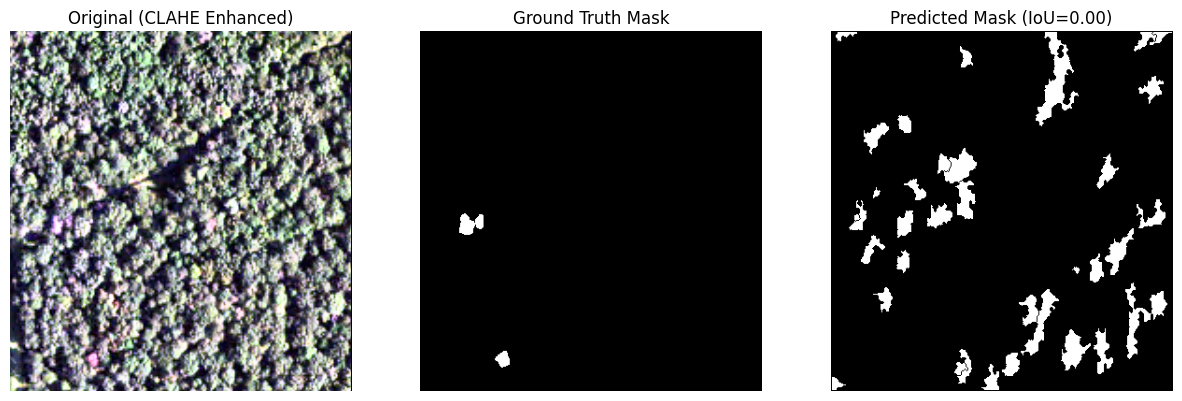

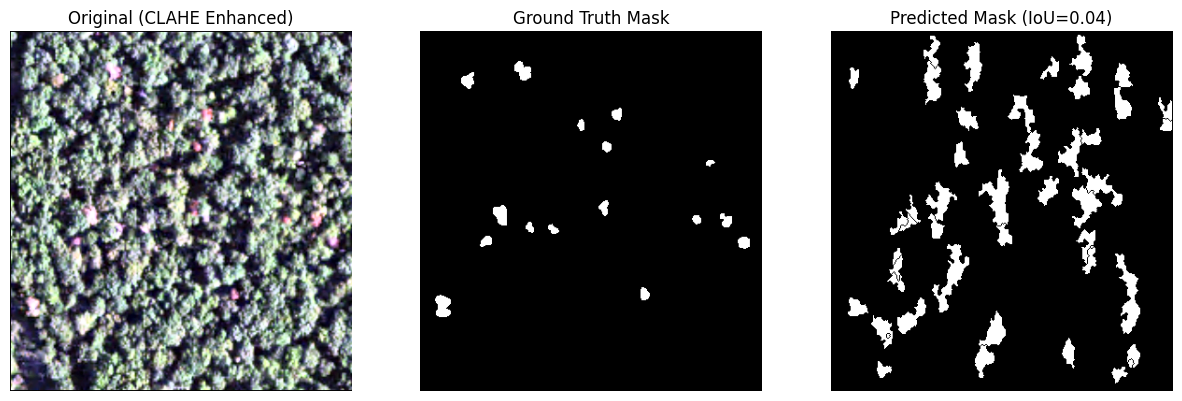

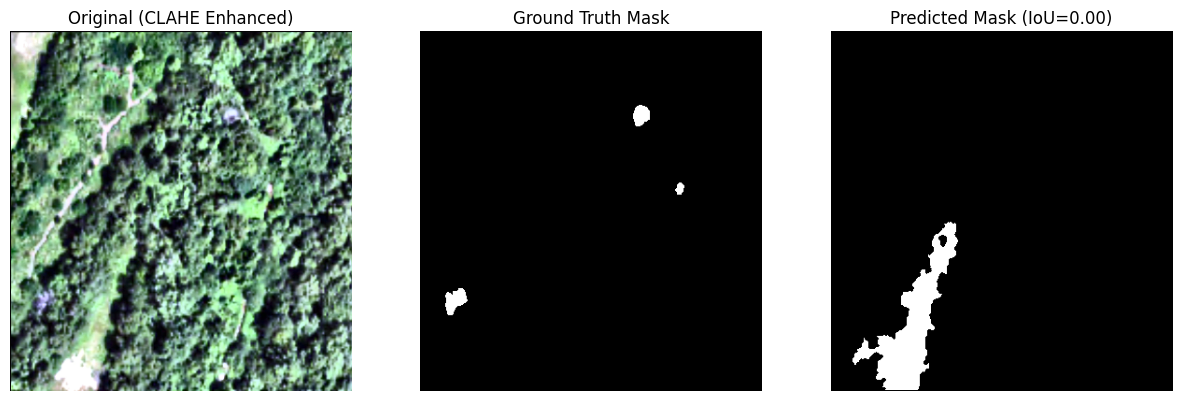

In [3]:
# Watershed
print("Running Watershed")
ious_ws = []
start_ws = time.time()

for idx, (img, gt_mask) in enumerate(zip(images, masks)):
    gt_mask = (gt_mask > 127).astype(np.uint8) * 255

    # CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Grayscale + Blur
    gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)

    # Threshold (Otsu)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    # Background region by dilation
    sure_bg = cv2.dilate(opening, kernel, iterations=2)

    # Foreground via distance transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Unknown region = bg - fg
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply watershed on gray image
    watershed_input = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
    watershed_input = cv2.cvtColor(watershed_input, cv2.COLOR_GRAY2BGR)  # still needs 3 channels
    markers = cv2.watershed(watershed_input, markers)

    # Generate binary mask
    pred_mask = np.zeros_like(gray)
    pred_mask[markers > 1] = 255

    # IoU
    iou = compute_iou(pred_mask, gt_mask)
    ious_ws.append(iou)

    if idx < 3:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB))
        plt.title("Original (CLAHE Enhanced)")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f"Predicted Mask (IoU={iou:.2f})")
        plt.axis('off')
        plt.show()

end_ws = time.time()

Method 2: MeanShift

Running MeanShift


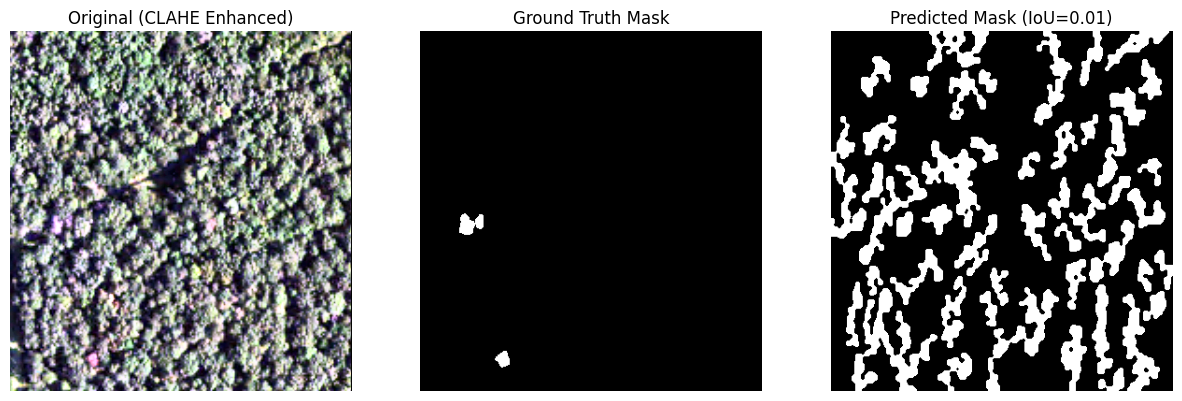

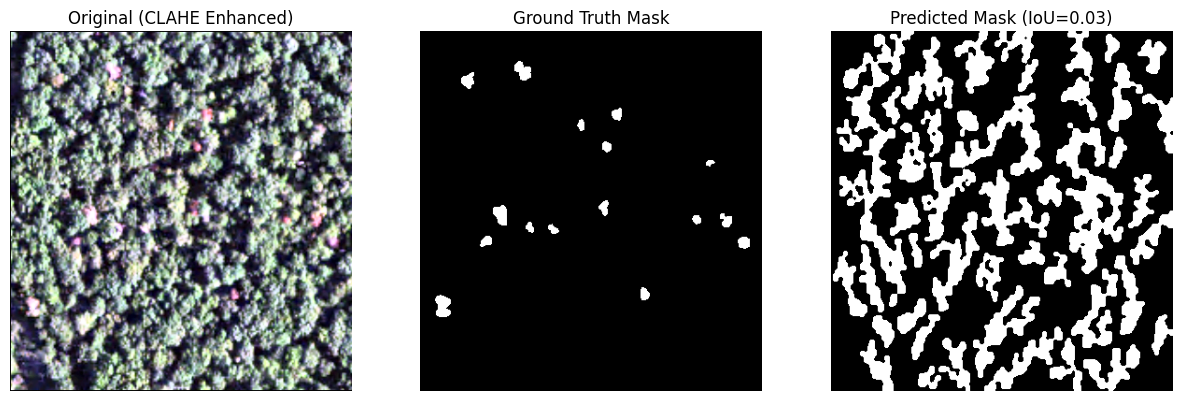

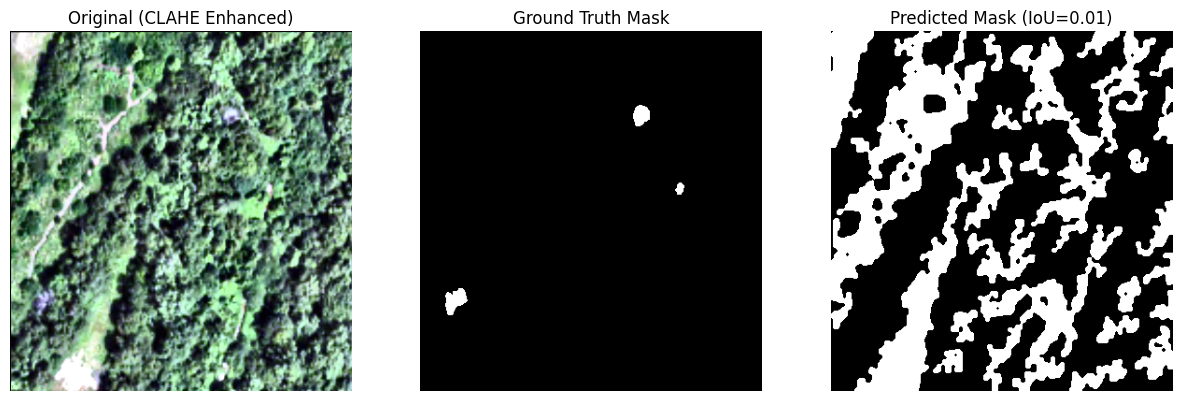

In [4]:
# MeanShift
print("Running MeanShift")
ious_ms = []
start_ms = time.time()

for idx, (img, gt_mask) in enumerate(zip(images, masks)):
    gt_mask = (gt_mask > 127).astype(np.uint8) * 255

    # CLAHE enhancement
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    shifted = cv2.pyrMeanShiftFiltering(img_clahe, sp=20, sr=20)

    # Convert to grayscale + blur
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Thresholding
    _, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological cleaning: open + close
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)
    cleaned = cv2.medianBlur(cleaned, 3)  # Smooth boundary

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned, connectivity=8)
    min_area = 300
    final_mask = np.zeros_like(cleaned)
    for i in range(1, num_labels):  # skip background
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            final_mask[labels == i] = 255

    # IoU
    iou = compute_iou(final_mask, gt_mask)
    ious_ms.append(iou)

    if idx < 3:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB))
        plt.title("Original (CLAHE Enhanced)")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(final_mask, cmap='gray')
        plt.title(f"Predicted Mask (IoU={iou:.2f})")
        plt.axis('off')
        plt.show()

end_ms = time.time()

In [5]:
# print result
print(f"Watershed mean IoU(RGB): {np.mean(ious_ws):.4f}, time: {end_ws - start_ws:.2f}s")
print(f"MeanShift mean IoU(RGB): {np.mean(ious_ms):.4f}, time: {end_ms - start_ms:.2f}s")

Watershed mean IoU(RGB): 0.0155, time: 4.11s
MeanShift mean IoU(RGB): 0.0286, time: 853.55s
